In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from numba import jit
import models as md
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox
from IPython.display import display
import ipywidgets as widgets

# Feedforward inhibition model

In [2]:
@jit
def jit_ffi_model(tau_m, e_l, r_m, stimulus, noise_exc, noise_inh, v_t, dt, total_time, init_vm_std, vt_std, rho_null,
                  tau_inh, rho_scale, init_period):
    ntime_steps = int((total_time+init_period)/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    v_t = np.random.normal(loc=v_t, scale=vt_std, size=ntime_steps)
    rho_inh = np.zeros(ntime_steps)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        # calculate activation of inhibitory population
        rho_inh[t] = rho_inh[t-1] + dt*(rho_null - rho_inh[t-1] + rho_scale*stimulus[t])/tau_inh + noise_inh[t]
        if t%0.01 == 0:
            print(rho_inh[t])
        # calculate lif dynamics with inhibitory input
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t] - rho_inh[t-1])/tau_m + noise_exc[t]
        if v_m[t] > v_t[t]:
            v_m[t] = e_l
            if t*dt > init_period:
                t_spks.append(t*dt)
                idx_spks.append(t)
        t = t + 1
    
    return time_points, v_m, t_spks, idx_spks, rho_inh

In [3]:
def calc_response(params):
    # sample lv values uniformly between lv_min and lv_max
    lv = np.random.rand()*(params['lv_max']-params['lv_min']) + params['lv_min']
    # sample stimulus sizes (L) uniformly between l_min and l_max
    #stim_size = np.random.rand()*(params['l_max']-params['l_min']) + params['l_min']
    stim_size = np.random.randint(params['l_min'], params['l_max'])
    speed = 1/(lv/stim_size)
    t, stims, tstims, dists, t_to_coll, tstim_to_coll = md.transform_stim(stim_size, speed, params['total_time'],
                                                                          params['dt'], params['m'], params['b'],
                                                                          params['init_period'], params['cutoff_angle'],
                                                                          params['init_distance'])

    stimulus = tstims*1e-11*params['exc_scale']
    sigma_exc = params['noise_std_exc'] * np.sqrt(params['dt'])
    sigma_inh = params['noise_std_inh'] * np.sqrt(params['dt'])
    noise_exc = np.random.normal(loc=0.0, scale=sigma_exc, size=len(stimulus))
    noise_inh = np.random.normal(loc=0.0, scale=sigma_inh, size=len(stimulus))

    #rho_null = np.random.lognormal(mean=params['rho_null'], sigma=params['rho_null_std'])
    rho_null = np.random.exponential(scale=params['rho_null'])
    rho_null = rho_null/1000
    time, v_m, spks, spk_idc, rho_inh = jit_ffi_model(params['tau_m'], params['e_l'], params['r_m'], stimulus, noise_exc,
                                                      noise_inh, params['v_t'], params['dt'], params['total_time'],
                                                      params['init_vm_std'], params['vt_std'], rho_null,
                                                      params['tau_inh'], params['rho_scale'], params['init_period'])
    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = -1
        first_spike_idx = -1
        
    if not first_spike_idx >= len(t_to_coll):
        resp_in_t_to_coll = t_to_coll[first_spike_idx]
    else:
        resp_in_t_to_coll = 0
        
    return stims[first_spike_idx], dists[first_spike_idx], first_spike, lv, stim_size, speed, resp_in_t_to_coll

In [4]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061
init_vm_std = 0.001
vt_std = 0.002

rho_null = 0.002
tau_inh = 0.001
rho_scale = 9.6*1e6

dt = 0.001
total_time = 5
init_period = 2
init_distance = 160

noise_std_exc = 5*1e-3
noise_std_inh = 5*1e-3
n_timepoints = int((total_time+ init_period)/dt)

# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 45
speeds = 1/(LV_vals/stim_size)
speed = speeds[2]
speed = 200
cutoff_angle = 180
m = 3
b = 0

t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = md.transform_stim(stim_size, speed, total_time, dt,
                                                                                           m, b, init_period,cutoff_angle)

stimulus = tstims*1*1e-11
sigma_exc = noise_std_exc * np.sqrt(dt)
sigma_inh = noise_std_inh * np.sqrt(dt)
noise_exc = np.random.normal(loc=0.0, scale=sigma_exc, size=n_timepoints)
noise_inh = np.random.normal(loc=0.0, scale=sigma_inh, size=n_timepoints)
time, v_m, spks, spk_idc, rho_inh = jit_ffi_model(tau_m, e_l, r_m, stimulus, noise_exc, noise_inh, v_t, dt, total_time,
                                                  init_vm_std, vt_std, rho_null, tau_inh, rho_scale, init_period)
first_spike = spks[0]
first_spike_idx = spk_idc[0]

IndexError: list index out of range

NameError: name 'first_spike_idx' is not defined

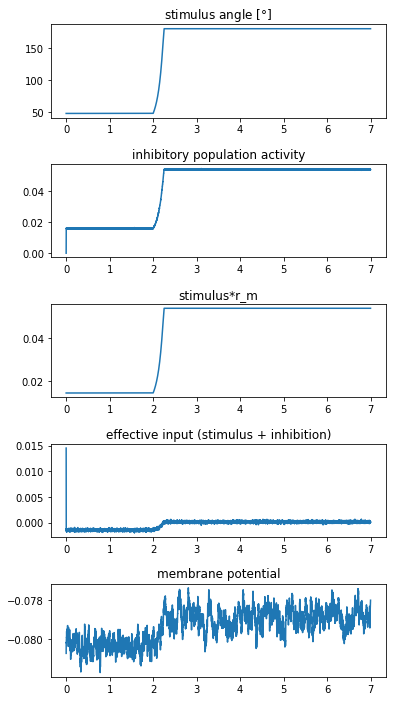

In [5]:
fig, axes = plt.subplots(5, 1, figsize=(6,12))
axes[0].plot(time, stims)
axes[0].set_title(r'stimulus angle [$ \degree $]')
#axes[0].set_ylim([0, 100])
axes[1].plot(time, rho_inh)
axes[1].set_title('inhibitory population activity')
axes[2].plot(time, stimulus*r_m)
axes[2].set_title('stimulus*r_m')
axes[3].plot(time, stimulus*r_m - rho_inh)
axes[3].set_title('effective input (stimulus + inhibition)')
axes[4].plot(time, v_m)
axes[4].set_title('membrane potential')
if not len(spks) == 0:
    axes[4].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)
print('Response angle at first spike: ' + str(stims[first_spike_idx]) + ' degree')
print('Distance at first spike: ' + str(dists[first_spike_idx]) + ' mm')

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot()
plt.grid(False)
ax.plot(time, v_m, color='#cc0000')
ax.set_facecolor('w')
plt.savefig('vm_example.svg')

## One parameter set example

Mean visual angle: 27.461244110942076
Mean distance: 36.575462591180944
Mean reaction time: 2.556782
resp in ttc: -0.9379999999999997


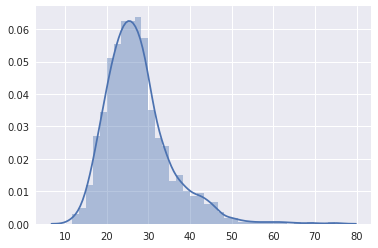

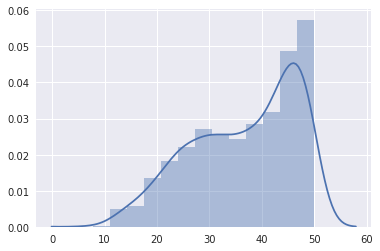

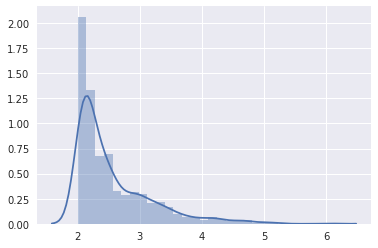

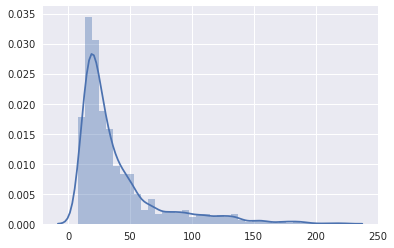

In [6]:
# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[1]

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.004,
          'rho_null': 2,
          'rho_null_std': 1,
          'tau_inh': 0.001,
          'rho_scale': 9.6*1e6,
          'exc_scale': 30,
          'dt': 0.001,
          'total_time': 5,
          'init_period': 2,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'cutoff_angle': 180,
          'm': 3,
          'b': 0,
          'lv_min': 0.1,
          'lv_max': 1.2,
          'l_min': 10,
          'l_max': 25,
          'init_distance': 50}

nruns = 1000
rstims = np.zeros(nruns)
rdists = np.zeros(nruns)
reaction_times = np.zeros(nruns)
speeds = np.zeros(nruns)
for i in np.arange(nruns):
    rstims[i], rdists[i], reaction_times[i], lv, stim_size, speeds[i], resp_in_t_to_coll = calc_response(params)

sns.set()
sns.distplot(rstims)
print('Mean visual angle: ' + str(np.mean(rstims)))
plt.figure()
sns.distplot(rdists)
print('Mean distance: ' + str(np.mean(rdists)))
plt.figure()
sns.distplot(reaction_times)
plt.figure()
sns.distplot(speeds)
print('Mean reaction time: ' + str(np.mean(reaction_times)))
print('resp in ttc: ' + str(resp_in_t_to_coll))

# Analyzing the effects of parameters of the inhibitory population

In [7]:
45/200

0.225

In [8]:
def plot_response_props(exc_scale, inh_scale, vt_std, rho_null, rho_null_std, tau_inh, cutoff_angle, exc_noise, m):
    params = {'tau_m': 0.023,
              'e_l': -0.079,
              'r_m': 10*1e6, # MOhm
              'v_t': -0.061,
              'init_vm_std': 0.0,
              'vt_std': vt_std/1000,
              'rho_null': rho_null,
              'rho_null_std': rho_null_std,
              'tau_inh': tau_inh/1000,
              'rho_scale': inh_scale*1e6,
              'exc_scale': exc_scale,
              'dt': 0.0005,
              'total_time': 10,
              'init_period': 2,
              'cutoff_angle': cutoff_angle,
              'noise_std_exc': exc_noise/1000,
              'noise_std_inh': 0*1e-3,
              'm': m,
              'b': 0,
              'lv_min': 0.02,
              'lv_max': 1.2,
              'l_min': 6,
              'l_max': 45,
              'init_distance': 160}
    nruns = 250
    data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'resp_time_coll']
    data_dict = dict([(col_name, []) for col_name in data_cols])

    for i in np.arange(nruns):
        resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
        resp_angle = np.round(resp_angle, decimals=1)
        resp_dist = np.round(resp_dist, decimals=1)
        resp_time = np.round(resp_time, decimals=3)
        lv = np.round(lv, decimals=2)
        stim_size = np.round(stim_size, decimals=1)
        speed = np.round(speed, decimals=1)
        resp_time_coll = np.round(resp_time_coll, decimals=3)
        result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll]
        for col, value in zip(data_cols, result_values):
            data_dict[col].append(value)

    df = pd.DataFrame(data_dict)
    
    sns.set('poster')
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
    sns.regplot(x='resp_dist', y='lv', data=df, fit_reg=False, ax=axes[0,0])
    axes[0,0].set_ylim([0, 1.3])
    axes[0,0].set_xlim([0, 50])
    
    sns.regplot(x='resp_time', y='lv', data=df, fit_reg=False, ax=axes[0,1])
    # plot preuss2006 data
    lv_vals = np.array([0.075, 0.036, 0.02, 0.044, 0.055, 0.11, 0.03])
    latency_vals = np.array([0.1, 0.19, 0.22, 0.24, 0.3, 0.42, 0.7])
    axes[0,1].plot(latency_vals+params['init_period'], lv_vals, 'k.', ms=20)
    #axes[0,1].set_xlim([2, 3])
    
    sns.regplot(x='lv', y='resp_angle', data=df, fit_reg=False, ax=axes[1,0])
    # plot preuss2006 data
    theta_vals = np.array([28, 24, 14, 21, 19, 22, 16])
    axes[1,0].plot(lv_vals, theta_vals, 'k.', ms=20)
    axes[1,0].set_ylim([0, 180])
    axes[1,0].set_xlim([0, 1.3])
    
    sns.regplot(x='resp_time_coll', y='lv', data=df, fit_reg=False, ax=axes[1,1])
    axes[1,1].set_ylim([0, 1.3])
    axes[1,1].set_xlim([-5, 0])

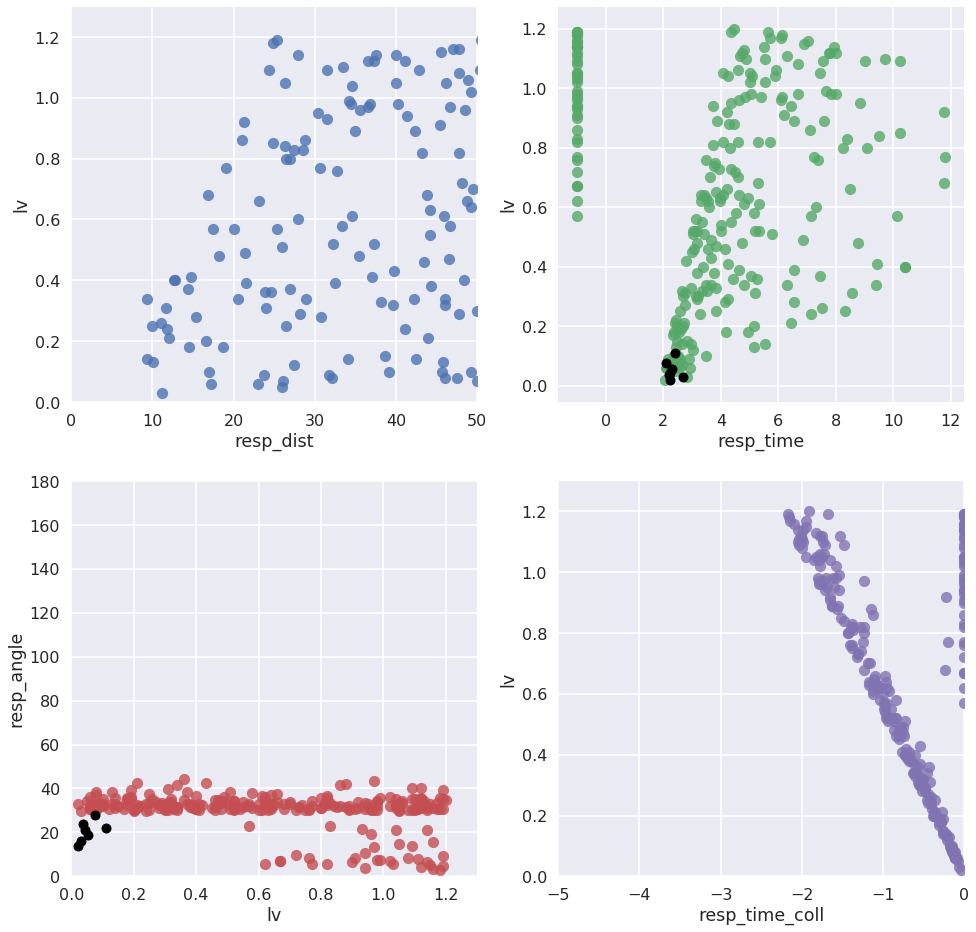

In [9]:
plot_response_props(exc_scale=30, inh_scale=9.6, vt_std=0, rho_null=2, rho_null_std=0, tau_inh=1, cutoff_angle=180, exc_noise=0, m=5)

## Looking at data from Preuss et al. 2006

In [10]:
print('L/V value for stimulus 1: ' +  str(45/600))
print('L/V value for stimulus 2: ' +  str(22/600))
print('L/V value for stimulus 3: ' +  str(12/600))
print('L/V value for stimulus 4: ' +  str(22/500))
print('L/V value for stimulus 5: ' +  str(22/400))
print('L/V value for stimulus 6: ' +  str(22/200))
print('L/V value for stimulus 7: ' +  str(6/200))

L/V value for stimulus 1: 0.075
L/V value for stimulus 2: 0.03666666666666667
L/V value for stimulus 3: 0.02
L/V value for stimulus 4: 0.044
L/V value for stimulus 5: 0.055
L/V value for stimulus 6: 0.11
L/V value for stimulus 7: 0.03


Text(0,0.5,'L/V [s]')

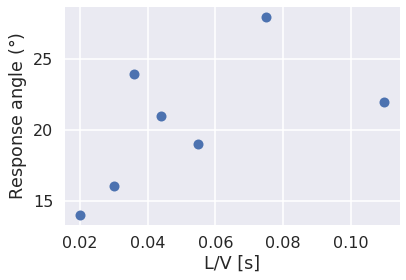

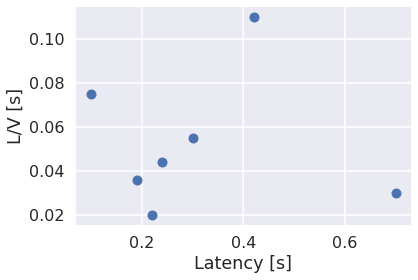

In [11]:
lv_vals = np.array([0.075, 0.036, 0.02, 0.044, 0.055, 0.11, 0.03])
theta_vals = np.array([28, 24, 14, 21, 19, 22, 16])
plt.figure()
plt.plot(lv_vals, theta_vals, '.', ms=20)
plt.xlabel('L/V [s]')
plt.ylabel('Response angle ($\degree$)')

latency_vals = np.array([0.1, 0.19, 0.22, 0.24, 0.3, 0.42, 0.7])
plt.figure()
plt.plot(latency_vals, lv_vals, '.', ms=20)
plt.xlabel('Latency [s]')
plt.ylabel('L/V [s]')

## Data from Dill 1974

In [16]:
sizes = np.array([25.4]*4 + [38.1]*4 + [50.8]*4)
velocities = np.array([115.8, 435.9, 627.9, 1085.1]*3)
dill_lv_values = sizes/velocities
dill_response_distances = np.array([111.6, 138.0, 204.0, 252.0, 182.1, 224.1, 249.6, 330.0, 99.0, 248.1, 264.9, 313.5])
dill_response_angles = np.arctan2(sizes/2, dill_response_distances)*2
dill_response_angles_degrees = dill_response_angles/np.pi*180
print(sizes)
print(velocities)
print(dill_lv_values)
print(dill_response_angles_degrees)

[25.4 25.4 25.4 25.4 38.1 38.1 38.1 38.1 50.8 50.8 50.8 50.8]
[ 115.8  435.9  627.9 1085.1  115.8  435.9  627.9 1085.1  115.8  435.9
  627.9 1085.1]
[0.2193437  0.05827025 0.0404523  0.02340798 0.32901554 0.08740537
 0.06067845 0.03511197 0.43868739 0.11654049 0.0809046  0.04681596]
[12.98457824 10.51612349  7.12469144  5.77016899 11.9443038   9.71768735
  8.72894754  6.60772475 28.77949755 11.69093131 10.95415028  9.26405668]


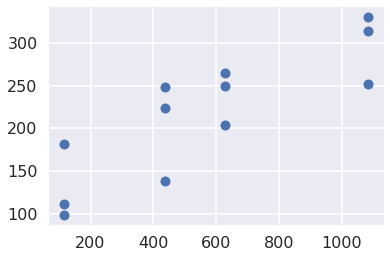

In [28]:
plt.plot(velocities, dill_response_distances, '.', ms=20)

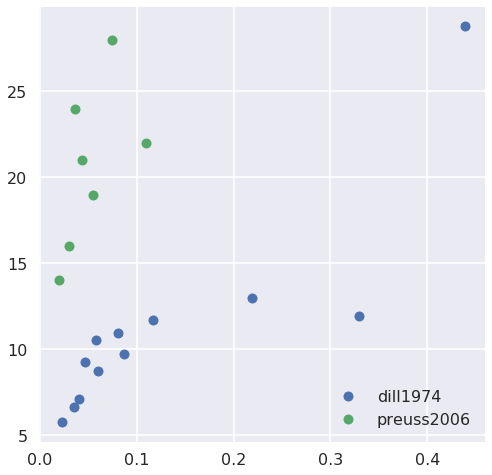

In [27]:
plt.figure(figsize=(8,8))
plt.plot(dill_lv_values, dill_response_angles_degrees, '.', ms=20, label='dill1974')
plt.plot(lv_vals, theta_vals, '.', ms=20, label='preuss2006')
plt.legend()

In [ ]:
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.000,
          'vt_std': 0.002,
          'rho_null': 2,
          'rho_null_std': 1.2,
          'tau_inh': 0.001,
          'rho_scale': 9.6*1e6,
          'exc_scale': 30,
          'dt': 0.001,
          'total_time': 5,
          'init_period': 2,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'cutoff_angle': 180,
          'm': 3,
          'b': 0,
          'lv_min': 0.01,
          'lv_max': 0.225,
          'l_min': 6,
          'l_max': 45,
          'init_distance': 160}
nruns = 250
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'resp_time_coll']
data_dict = dict([(col_name, []) for col_name in data_cols])

for i in np.arange(nruns):
    resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
    resp_angle = np.round(resp_angle, decimals=1)
    resp_dist = np.round(resp_dist, decimals=1)
    resp_time = np.round(resp_time, decimals=3)
    lv = np.round(lv, decimals=2)
    stim_size = np.round(stim_size, decimals=1)
    speed = np.round(speed, decimals=1)
    resp_time_coll = np.round(resp_time_coll, decimals=3)
    result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll]
    for col, value in zip(data_cols, result_values):
        data_dict[col].append(value)

df = pd.DataFrame(data_dict)

In [ ]:
plt.figure()
sns.regplot(x='resp_dist', y='lv', data=df, fit_reg=False)
plt.figure()
sns.regplot(x='resp_time', y='lv', data=df, fit_reg=False)
latency_vals = np.array([0.1, 0.19, 0.22, 0.24, 0.3, 0.42, 0.7])
plt.plot(latency_vals+2, lv_vals, 'r.', ms=20)
plt.figure()
sns.regplot(x='lv', y='resp_angle', data=df, fit_reg=False)
plt.plot(lv_vals, theta_vals, 'r.', ms=20)
plt.figure()
sns.regplot(x='resp_time_coll', y='lv', data=df, fit_reg=False)
plt.ylim([0, 0.3])
plt.xlim([-1, 0])
plt.figure()
sns.regplot(x='stim_size', y='resp_angle', data=df, fit_reg=False)
plt.figure()
sns.regplot(x='resp_time', y='resp_angle', data=df, fit_reg=False)

In [ ]:
#parameter sliders
exc_scale_slider = widgets.FloatSlider(min=1, max=200, step=1, value=33, continuous_update=False)
inh_scale_slider = widgets.FloatSlider(min=1, max=20, step=0.2, value=9.6, continuous_update=False)
vt_std_slider = widgets.FloatSlider(min=0, max=5, step=1, value=1, continuous_update=False)
rho_null_slider = widgets.FloatSlider(min=0, max=10, step=0.5, value=2, continuous_update=False)
rho_null_std_slider = widgets.FloatSlider(min=0, max=5, step=0.1, value=0.2, continuous_update=False)
tau_inh_slider = widgets.FloatSlider(min=0.05, max=25, step=0.5, value=1, continuous_update=False)
cutoff_slider = widgets.FloatSlider(min=120, max=180, step=10, value=150, continuous_update=False)
exc_noise_slider = widgets.FloatSlider(min=0, max=20, step=1, value=5, continuous_update=False)
m_slider = widgets.FloatSlider(min=1, max=6, step=0.5, value=3, continuous_update=False)

plotgroup = interactive(plot_response_props, exc_scale=exc_scale_slider, inh_scale=inh_scale_slider,
                        vt_std=vt_std_slider, rho_null=rho_null_slider, rho_null_std=rho_null_std_slider,
                        tau_inh=tau_inh_slider, cutoff_angle=cutoff_slider, exc_noise=exc_noise_slider, m=m_slider)

# refresh button
button = widgets.Button(description='Refresh')
def on_button_clicked(b):
    plotgroup.update()
button.on_click(on_button_clicked)

# combine sliders and button
allgroups = HBox(children=[plotgroup, button])

In [ ]:
allgroups